#Download & Extract Data

In [ ]:
!kaggle datasets download -d splcher/animefacedataset
!unzip /content/animefacedataset.zip

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/animefacedataset.zip
replace images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set
!unzip /content/cartoon-faces-googles-cartoon-set.zip

#Import libraries

In [2]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
from torchsummary import summary
import torch.nn.functional as F

#Data Preprocessing

In [3]:
# Check for GPUs and set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
cartoon_faces_base_folder = '/content/cartoonset100k_jpg'

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Randomly select 5 folders of cartoon faces
cartoon_folders = os.listdir(cartoon_faces_base_folder)
selected_folders = random.sample(cartoon_folders, 5)
cartoon_images = []
cartoon_labels = []
for folder in selected_folders:
    folder_path = os.path.join(cartoon_faces_base_folder, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    half_files = files[:len(files)]
    for filename in half_files:
        cartoon_images.append(os.path.join(folder_path, filename))
        cartoon_labels.append(1)

# Combine datasets
all_images = cartoon_images
all_labels = cartoon_labels

# Create dataset and dataloader
dataset = ImageDataset(image_paths=all_images, labels=all_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [6]:
len(dataset)

50000

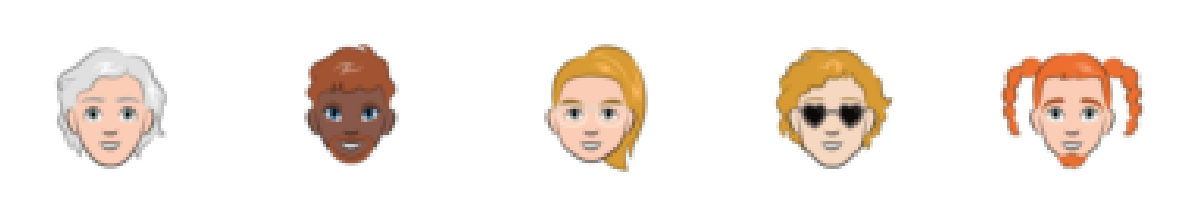

In [7]:
# Randomly sample 5 images
random_images = random.sample(range(len(dataset)), 5)

# Display the images
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_images):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(dataset[idx][0].numpy(), (1,2,0)))
    plt.axis("off")
plt.show()

In [ ]:
# Custom sampling function
def sampling_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = torch.randn_like(log_var)  # Sample from a normal distribution
    return mean + torch.exp(log_var / 2) * epsilon

In [ ]:
# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.block1 = ResNetBlock(3, 32, stride=2)
        self.block2 = ResNetBlock(32, 64, stride=2)
        self.fc_mean = nn.Linear(64 * 16 * 16, latent_dim)
        self.fc_log_var = nn.Linear(64 * 16 * 16, latent_dim)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean,log_var

In [ ]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, mean, log_var):
        epsilon = torch.randn_like(mean)  # Sample from a normal distribution
        return mean + torch.exp(log_var / 2) * epsilon

class Encoder2(nn.Module):
    def __init__(self, input_shape1, input_shape2):
        super(Encoder2, self).__init__()
        self.sampling = Sampling()

    def forward(self, mean, log_var):
        return self.sampling(mean, log_var)


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 16)
        self.block1 = ResNetBlock(64, 32, stride=1)
        self.block2 = ResNetBlock(32, 3, stride=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 16, 16)
        x = self.up1(x)
        x = self.block1(x)
        x = self.up2(x)
        x = self.block2(x)
        x_reconstructed = torch.sigmoid(x)
        x_reconstructed = x_reconstructed.view(-1, 3, 64, 64)
        return x_reconstructed

In [ ]:
# Define reconstruction loss (MSE)
def mse_loss(y_true, y_pred):
    return  F.binary_cross_entropy(recon_x, x, reduction='mean')

# Define KL divergence loss
def kl_loss(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)

# Define VAE loss
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_ = kl_loss(mean, log_var)
    return r_loss + kl_loss_.mean(), r_loss.mean(), kl_loss_.mean()


In [ ]:
latent_dim = 128

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)

        self.sampling = Encoder2(latent_dim,latent_dim)

        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.sampling(mean, log_var)
        recon_x = self.decoder(z)

        kl_loss = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())

        return kl_loss, recon_x

In [ ]:
import numpy as np

def generate_image(model):
    model.eval()
    with torch.no_grad():
        # Sample from the latent space (assuming standard normal distribution for simplicity)
        z = torch.randn(8, latent_dim).to(device)

        generated_images = model.decoder(z)
        generated_images = generated_images.squeeze(0).cpu().detach().numpy()  # Convert tensor to numpy array

    # Rescale pixel values to range [0, 1]
    generated_images = np.clip(generated_images, 0, 1)

    # Plot the generated image
    plt.figure(figsize=(6*8, 6))
    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(np.transpose(generated_images[i], (1,2,0)))
        plt.axis("off")
    plt.show()

6407139


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/5], Batch [1/1563], Loss: 0.8576
Epoch [1/5], Batch [101/1563], Loss: 0.4202
Epoch [1/5], Batch [201/1563], Loss: 0.3294
Epoch [1/5], Batch [301/1563], Loss: 0.3152
Epoch [1/5], Batch [401/1563], Loss: 0.2905
Epoch [1/5], Batch [501/1563], Loss: 0.2866
Epoch [1/5], Batch [601/1563], Loss: 0.2672
Epoch [1/5], Batch [701/1563], Loss: 0.2697
Epoch [1/5], Batch [801/1563], Loss: 0.2631
Epoch [1/5], Batch [901/1563], Loss: 0.2382
Epoch [1/5], Batch [1001/1563], Loss: 0.2524
Epoch [1/5], Batch [1101/1563], Loss: 0.2407
Epoch [1/5], Batch [1201/1563], Loss: 0.2360
Epoch [1/5], Batch [1301/1563], Loss: 0.2474
Epoch [1/5], Batch [1401/1563], Loss: 0.2504
Epoch [1/5], Batch [1501/1563], Loss: 0.2326


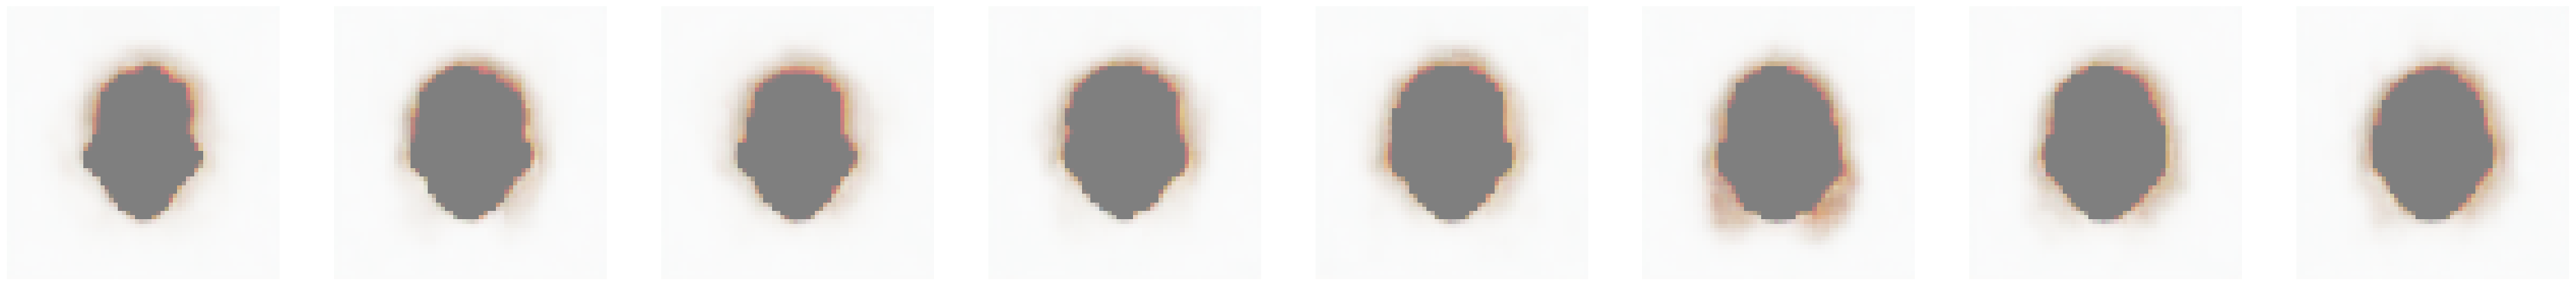

Epoch [1/5], Total Loss: 0.4949
Epoch [1/5], Total Recon Loss: 0.2608
Epoch [2/5], Batch [1/1563], Loss: 0.2386
Epoch [2/5], Batch [101/1563], Loss: 0.2205
Epoch [2/5], Batch [201/1563], Loss: 0.2154
Epoch [2/5], Batch [301/1563], Loss: 0.2397
Epoch [2/5], Batch [401/1563], Loss: 0.2215
Epoch [2/5], Batch [501/1563], Loss: 0.2214
Epoch [2/5], Batch [601/1563], Loss: 0.2330
Epoch [2/5], Batch [701/1563], Loss: 0.2229
Epoch [2/5], Batch [801/1563], Loss: 0.2225
Epoch [2/5], Batch [901/1563], Loss: 0.2239
Epoch [2/5], Batch [1001/1563], Loss: 0.2117
Epoch [2/5], Batch [1101/1563], Loss: 0.2216
Epoch [2/5], Batch [1201/1563], Loss: 0.2225
Epoch [2/5], Batch [1301/1563], Loss: 0.2205
Epoch [2/5], Batch [1401/1563], Loss: 0.2156
Epoch [2/5], Batch [1501/1563], Loss: 0.2162


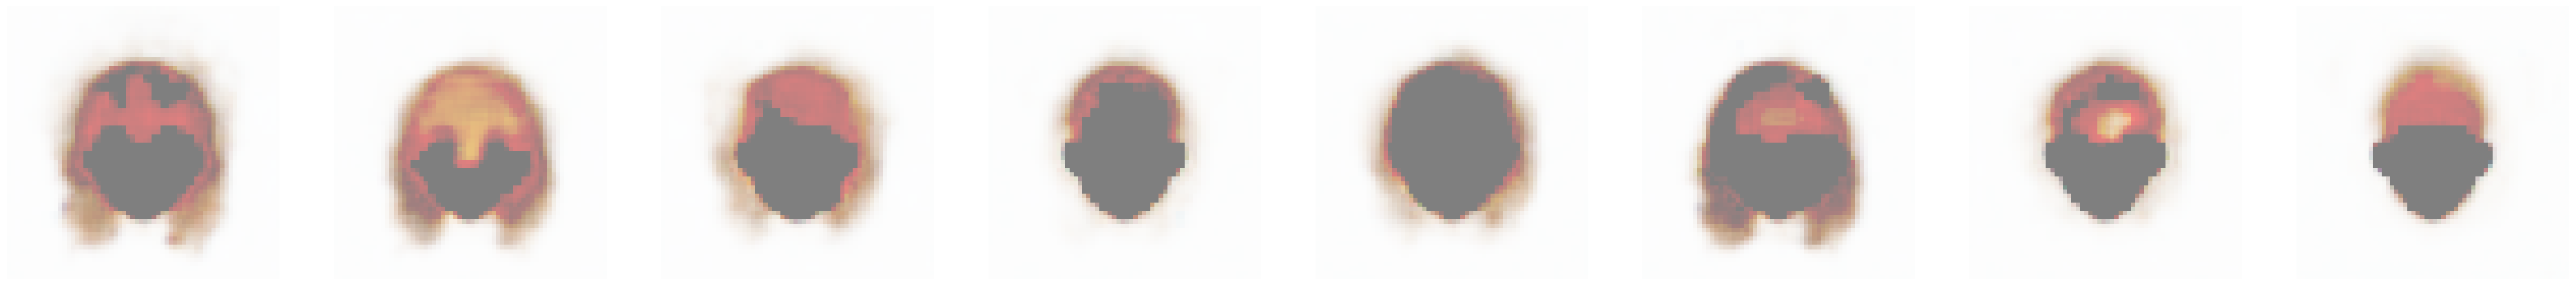

Epoch [2/5], Total Loss: 0.2206
Epoch [2/5], Total Recon Loss: 0.2068
Epoch [3/5], Batch [1/1563], Loss: 0.2133
Epoch [3/5], Batch [101/1563], Loss: 0.2050
Epoch [3/5], Batch [201/1563], Loss: 0.2105
Epoch [3/5], Batch [301/1563], Loss: 0.1932
Epoch [3/5], Batch [401/1563], Loss: 0.2082
Epoch [3/5], Batch [501/1563], Loss: 0.2065
Epoch [3/5], Batch [601/1563], Loss: 0.2072
Epoch [3/5], Batch [701/1563], Loss: 0.2141
Epoch [3/5], Batch [801/1563], Loss: 0.2044
Epoch [3/5], Batch [901/1563], Loss: 0.1927
Epoch [3/5], Batch [1001/1563], Loss: 0.2082
Epoch [3/5], Batch [1101/1563], Loss: 0.1978
Epoch [3/5], Batch [1201/1563], Loss: 0.2041
Epoch [3/5], Batch [1301/1563], Loss: 0.2201
Epoch [3/5], Batch [1401/1563], Loss: 0.2100
Epoch [3/5], Batch [1501/1563], Loss: 0.1908


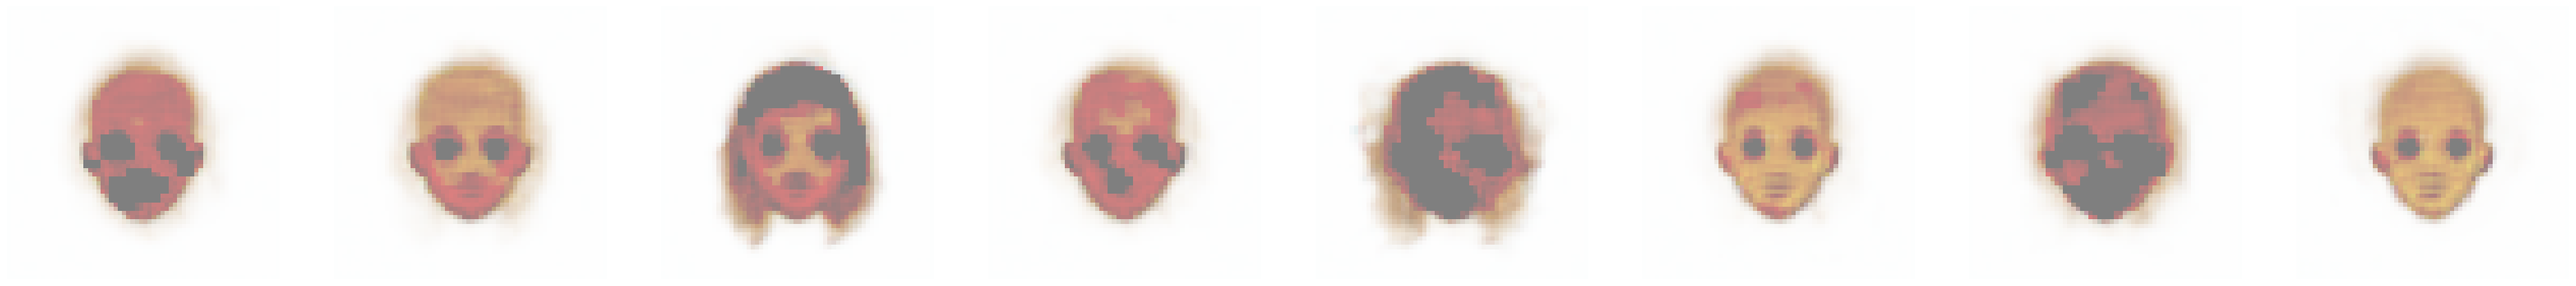

Epoch [3/5], Total Loss: 0.2081
Epoch [3/5], Total Recon Loss: 0.1958
Epoch [4/5], Batch [1/1563], Loss: 0.1964
Epoch [4/5], Batch [101/1563], Loss: 0.2185
Epoch [4/5], Batch [201/1563], Loss: 0.2058
Epoch [4/5], Batch [301/1563], Loss: 0.2107
Epoch [4/5], Batch [401/1563], Loss: 0.1835
Epoch [4/5], Batch [501/1563], Loss: 0.1934
Epoch [4/5], Batch [601/1563], Loss: 0.1979
Epoch [4/5], Batch [701/1563], Loss: 0.1885
Epoch [4/5], Batch [801/1563], Loss: 0.2014
Epoch [4/5], Batch [901/1563], Loss: 0.2243
Epoch [4/5], Batch [1001/1563], Loss: 0.2053
Epoch [4/5], Batch [1101/1563], Loss: 0.1907
Epoch [4/5], Batch [1201/1563], Loss: 0.1942
Epoch [4/5], Batch [1301/1563], Loss: 0.1850
Epoch [4/5], Batch [1401/1563], Loss: 0.2052
Epoch [4/5], Batch [1501/1563], Loss: 0.2005


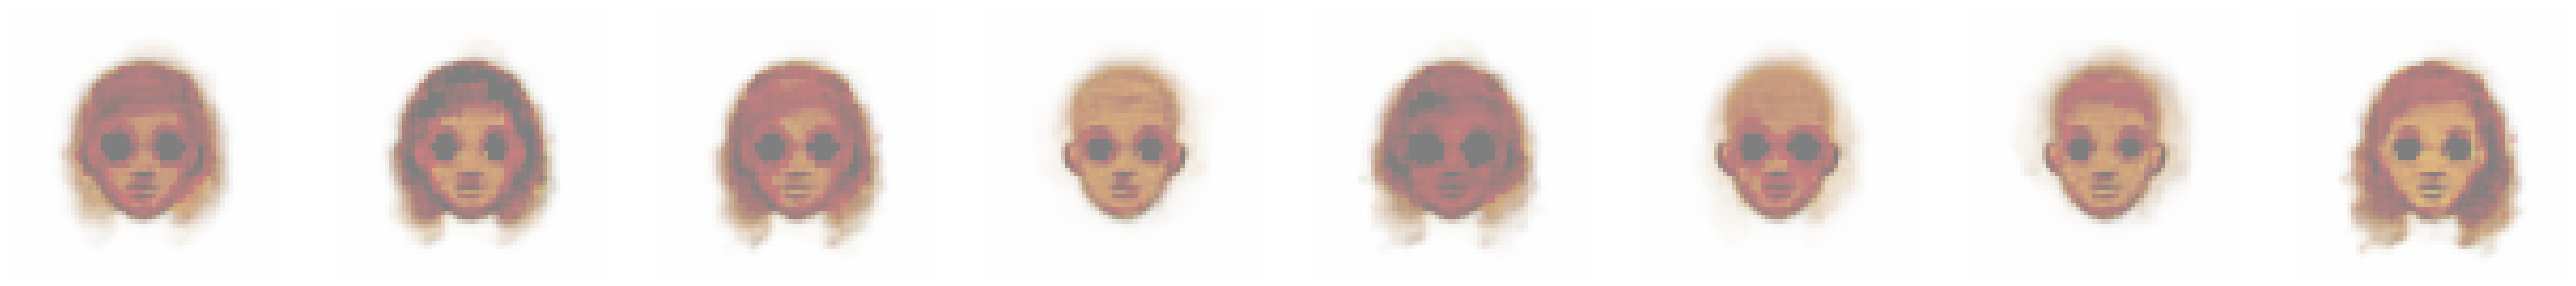

Epoch [4/5], Total Loss: 0.2019
Epoch [4/5], Total Recon Loss: 0.1907
Epoch [5/5], Batch [1/1563], Loss: 0.2005
Epoch [5/5], Batch [101/1563], Loss: 0.1883
Epoch [5/5], Batch [201/1563], Loss: 0.1981
Epoch [5/5], Batch [301/1563], Loss: 0.2039
Epoch [5/5], Batch [401/1563], Loss: 0.1823
Epoch [5/5], Batch [501/1563], Loss: 0.2077
Epoch [5/5], Batch [601/1563], Loss: 0.2015
Epoch [5/5], Batch [701/1563], Loss: 0.1943
Epoch [5/5], Batch [801/1563], Loss: 0.2150
Epoch [5/5], Batch [901/1563], Loss: 0.2035
Epoch [5/5], Batch [1001/1563], Loss: 0.2099
Epoch [5/5], Batch [1101/1563], Loss: 0.2045
Epoch [5/5], Batch [1201/1563], Loss: 0.1995
Epoch [5/5], Batch [1301/1563], Loss: 0.2085
Epoch [5/5], Batch [1401/1563], Loss: 0.2078
Epoch [5/5], Batch [1501/1563], Loss: 0.2090


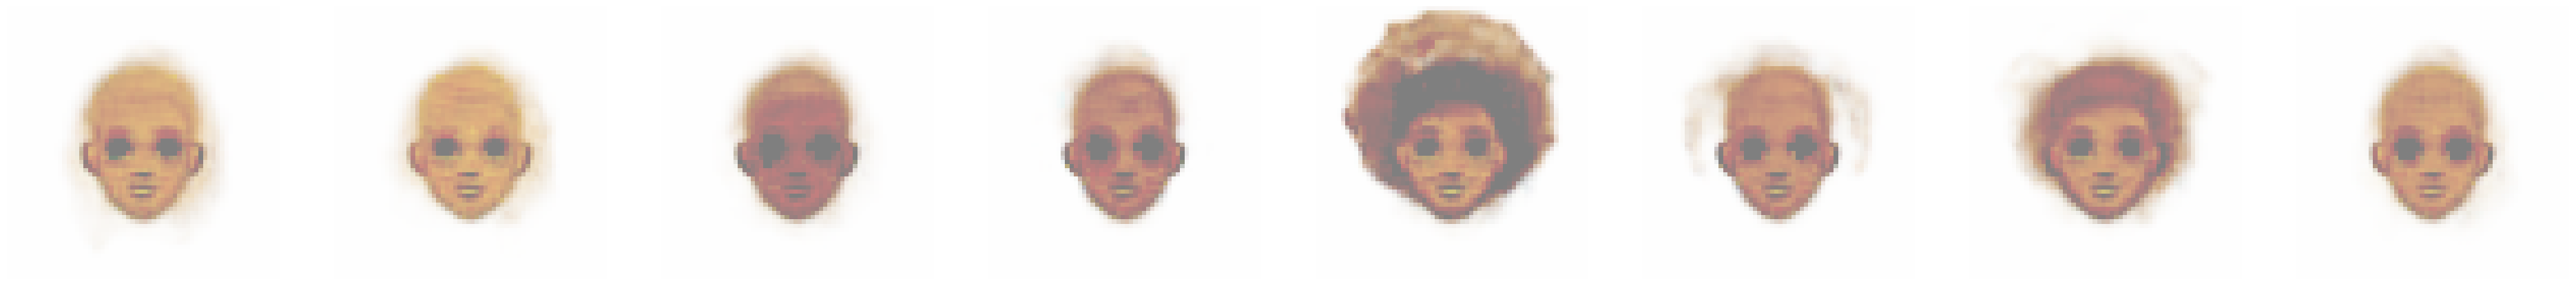

Epoch [5/5], Total Loss: 0.1991
Epoch [5/5], Total Recon Loss: 0.1884


In [ ]:
loss_ = []
r_l = []
kl_l = []
# Initialize VQVAE model
model = VAE(latent_dim).to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_recon_loss = 0
    total_loss=0
    total_kl_l = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()
        kl_loss, recon_x = model(x)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean')
        loss = recon_loss + kl_loss


        loss.backward()
        optimizer.step()

        total_recon_loss += recon_loss.item()
        total_loss += loss.item()
        total_kl_l += kl_loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

    generate_image(model)
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss / len(dataloader):.4f}")
    loss_.append(total_loss / len(dataloader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Recon Loss: {total_recon_loss / len(dataloader):.4f}")
    r_l.append(total_recon_loss / len(dataloader))


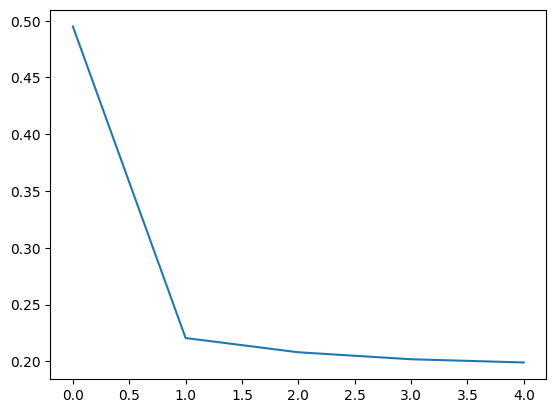

In [ ]:
plt.plot([np.mean(l) for l in loss_])

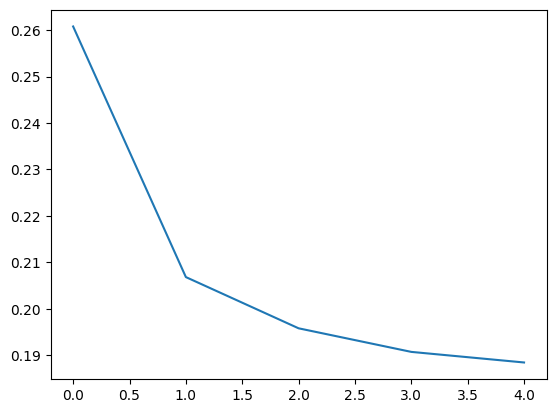

In [ ]:
plt.plot([np.mean(l) for l in r_l])